# 卷积神经网络
## 从全连接层到卷积
卷积层 = 全连接层 + 平移不变性 + 局部性

## 图像卷积
二维交叉相关和二维卷积差不多，多了一个负号，在实际应用中没有区别。

卷积层将输入和核矩阵进行交叉相关，加上偏移后得到输出。

核矩阵和偏移是可学习的参数，核矩阵的大小是超参数。

说白了，就是利用卷积核将高维的输入映射为低维的输出，实现特征提取。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):  #@save 计算二维互相关运算
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [2]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K) # 验证一下

tensor([[19., 25.],
        [37., 43.]])

In [3]:
class Conv2D(nn.Module): # 继承nn.Module实现类
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [4]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X # 边缘图像

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [5]:
K = torch.tensor([[1.0, -1.0]]) # 卷积核
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [6]:
corr2d(X.t(), K) # 经过转置后，该卷积核无法检测水平边缘。

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [7]:
# 如何自动学习卷积核，而不是手动设置？
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)
# 核的形状可以设置，但具体数值还需进一步学习
# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8)) # 输入
Y = Y.reshape((1, 1, 6, 7)) # 输出
lr = 3e-2  # 学习率

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 19.373
epoch 4, loss 6.824
epoch 6, loss 2.609
epoch 8, loss 1.037
epoch 10, loss 0.420


In [8]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0555, -0.9222]])

## 卷积层里的填充和步幅
填充和步幅是卷积层的超参数

填充在输入周围添加额外的行/列，来控制输出形状的减少量

假设输入形状为$n_h\times n_w$，卷积核形状为$k_h\times k_w$，那么输出形状将是$(n_h-k_h+1) \times (n_w-k_w+1)$。

如果我们添加$p_h$行填充（大约一半在顶部，一半在底部）和$p_w$列填充（左侧大约一半，右侧一半），则输出形状将为

$$(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1)。$$

这意味着输出的高度和宽度将分别增加$p_h$和$p_w$。

通常取$p_h=k_h-1$和$p_w=k_w-1$，当$k_h$是奇数，在上下两侧填充$p_h/2$行。当$k_h$是偶数，则在上侧填充$\lceil p_h/2\rceil$行，在下侧填充$\lfloor p_h/2\rfloor$行。

卷积核的高度和宽度通常为奇数。

步幅是每次滑动核窗口时的行/列的步长，可以成倍的减少输出形状

通常，当垂直步幅为$s_h$、水平步幅为$s_w$时，输出形状为：

$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$

如果$p_h=k_h-1$和$p_w=k_w-1$，则输出形状为$\lfloor(n_h+s_h-1)/s_h\rfloor \times \lfloor(n_w+s_w-1)/s_w\rfloor$。

如果输入的高度和宽度可以被垂直和水平步幅整除，则输出形状将为$(n_h/s_h) \times (n_w/s_w)$。

In [9]:
# 在所有侧边填充1个像素
import torch
from torch import nn

# 为了方便起见，我们定义了一个计算卷积层的函数。
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数
def comp_conv2d(conv2d, X):
    # 这里的（1，1）表示批量大小和通道数都是1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # 省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])

# 请注意，这里每边都填充了1行或1列，因此总共添加了2行或2列
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [10]:
# 填充不同的高度和宽度 2，1
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [11]:
# 高度和宽度的步幅为2
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [12]:
# 高度和宽度的步幅为3、4，填充0和1
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

## 多输入输出通道

多个输出通道：有多个三维卷积核，每个核生成一个输出通道

每一个输出通道用于识别特定模式

1*1卷积层：高宽都为1，不识别空间模式，只是融合通道。输入n维，则卷积核n维；有几个卷积核，就有几个通道。

- 输出通道数是卷积层的超参数
- 每个输入通道都有一个卷积核，结果是所有通道卷积结果的和
- 每个输出通道有独立的三维卷积核


In [13]:
# 实现多输入通道互相关运算
import torch
from d2l import torch as d2l

def corr2d_multi_in(X, K):
    # 先遍历“X”和“K”的第0个维度（通道维度），再把它们加在一起
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [14]:
# 验证
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [15]:
# 实现一个计算多个通道的输出的互相关函数
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

K = torch.stack((K, K + 1, K + 2), 0)
K.shape # torch.Size([3, 2, 2, 2]) 3个输出（K有三个），2个输入（X有两个2*3*3）

torch.Size([3, 2, 2, 2])

In [16]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [17]:
# 1*1卷积
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

## 池化层

二维最大池化：返回滑动窗口中的最大值

填充、步幅和多个通道：
   - 池化层和卷积层类似，都具有填充和步幅
   - 没有可学习的参数
   - 在每个输入通道应用池化层以获得相应的输出通道
   - 输入通道数=输出通道数

平均池化层：将最大池化层的最大操作替换为平均

- 池化层返回窗口中最大或平均值
- 缓解卷积层位置的敏感性
- 同样有窗口大小、填充和步幅作为超参数

In [18]:
# 实现池化层的正向传播
import torch
from torch import nn
from d2l import torch as d2l

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [19]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [20]:
pool2d(X, (2, 2), 'avg') # 平均池化层

tensor([[2., 3.],
        [5., 6.]])

In [21]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [22]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [23]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1)) # 步幅和填充
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [24]:
# 池化层在每个输入通道上单独运算
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [25]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## LeNet

留下了MNIST数据集

- 先使用卷积层来学习图片空间信息
- 通过池化层降低图片信息敏感度
- 然后使用全连接层来转换到类别空间


In [26]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [27]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [28]:
# LeNet在Fashion-MNIST数据集上的表现
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [29]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [30]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

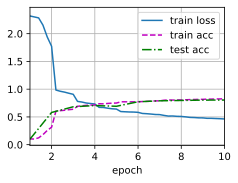

In [31]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())